In [119]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [120]:
bookings = pd.read_csv(r'C:\Users\torre\OneDrive\Escritorio\\Master UIV\Minería de datos\hotel_bookings.csv')
bookings.head()

,index,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01-07-15
1,1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01-07-15
2,2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,02-07-15
3,3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,02-07-15
4,4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,03-07-15


In [121]:
bookings.shape

(119390, 33)

Definimos los conjuntos de entrenamiento y test

In [122]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(bookings, test_size=0.2, stratify=bookings['is_canceled'])

# Selección, preprocesamiento y transformación

**Detección de tipos de datos e incorporación de nuevas columnas**

In [123]:
bookings.dtypes

index                               int64
hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                      

Nos encontramos con una problemática y es que considerando la importancia de los atributos reserved_room_type y assigned_room_type para nuestro objetivo, vemos que ambos son categóricos y por tanto no se los podremos pasar a un futuro modelo. Por ello vamos a crear un nuevo atributo que identifique cuando hay un cambio de tipo de habitación y que llamaremos room_is_changed. Cuando el tipo de habitación reservada sea distinta a la habitación asignada, nuestro atributo valdrá 1 y significará que ha habido cambios el el tipo de habitación.

In [124]:
df_train["room_is_changed"] = np.nan
df_test["room_is_changed"] = np.nan

<ipython-input-124-3a4a83a77467>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["room_is_changed"] = np.nan
<ipython-input-124-3a4a83a77467>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["room_is_changed"] = np.nan


In [125]:
df_train.loc[df_train['reserved_room_type'] == df_train['assigned_room_type'], 'room_is_changed'] = 0
df_train.loc[df_train['reserved_room_type'] != df_train['assigned_room_type'], 'room_is_changed'] = 1

df_test.loc[df_test['reserved_room_type'] == df_test['assigned_room_type'], 'room_is_changed'] = 0
df_test.loc[df_test['reserved_room_type'] != df_test['assigned_room_type'], 'room_is_changed'] = 1

C:\Users\torre\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Por otro lado nos interesa ver el numero de huespedes que tenemos pero no si son niños, adultos o bebes, por lo tanto combinaremos estos 3 atributos a una sola columna.

In [126]:
df_train['total_guests'] = df_train['adults'] + df_train['children'] + df_train['babies']
df_test['total_guests'] = df_test['adults'] + df_test['children'] + df_test['babies']

<ipython-input-126-4a2c6bee42be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['total_guests'] = df_train['adults'] + df_train['children'] + df_train['babies']
<ipython-input-126-4a2c6bee42be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['total_guests'] = df_test['adults'] + df_test['children'] + df_test['babies']


In [127]:
df_train['total_nights'] = df_train['stays_in_weekend_nights'] + df_train['stays_in_week_nights']
df_test['total_nights'] = df_test['stays_in_weekend_nights'] + df_test['stays_in_week_nights']

<ipython-input-127-72d0afde473a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['total_nights'] = df_train['stays_in_weekend_nights'] + df_train['stays_in_week_nights']
<ipython-input-127-72d0afde473a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['total_nights'] = df_test['stays_in_weekend_nights'] + df_test['stays_in_week_nights']


**Reducción de la dimensionalidad**

Eliminaremos el atributo index porque lo único que nos dice es el número de fila lo cual es para nada relevante ya que además las filas vienen numeradas por defecto.

In [128]:
df_train = df_train.drop(columns=['index'])
df_test = df_test.drop(columns=['index'])

Eliminaremos los atributos reserved_room_type y assigned_room_type ya que tenemos nuestro nuevo atributo room_is_changed que es el que nos interesa conservar.

In [130]:
df_train = df_train.drop(columns=['adults', 'children', 'babies'])
df_test = df_test.drop(columns=['adults', 'children', 'babies'])

In [129]:
df_train = df_train.drop(columns=['reserved_room_type', 'assigned_room_type'])
df_test = df_test.drop(columns=['reserved_room_type', 'assigned_room_type'])

In [131]:
df_train = df_train.drop(columns=['stays_in_weekend_nights', 'stays_in_week_nights'])
df_test = df_test.drop(columns=['stays_in_weekend_nights', 'stays_in_week_nights'])

In [132]:
df_train = df_train.drop(columns=['arrival_date_year', 'arrival_date_week_number', 
                                  'arrival_date_day_of_month', 'distribution_channel', 
                                  'reservation_status', 'reservation_status_date'])
df_test = df_test.drop(columns=['arrival_date_year', 'arrival_date_week_number', 
                                  'arrival_date_day_of_month', 'distribution_channel',
                                  'reservation_status', 'reservation_status_date'])

In [133]:
df_train.head()

,hotel,is_canceled,lead_time,arrival_date_month,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,room_is_changed,total_guests,total_nights
85625,City Hotel,0,16,March,BB,ESP,Online TA,0,0,0,1,No Deposit,9.0,NaN,0,Transient-Party,103.0,0,1,0.0,1.0,1
55256,City Hotel,1,82,August,BB,FRA,Online TA,0,0,0,0,No Deposit,9.0,NaN,0,Transient,150.3,0,2,0.0,3.0,8
7157,Resort Hotel,0,284,July,BB,PRT,Online TA,0,0,0,0,No Deposit,NaN,NaN,0,Transient,169.5,1,1,0.0,2.0,5
23544,Resort Hotel,0,2,April,BB,FRA,Direct,0,0,0,0,No Deposit,NaN,NaN,0,Transient,65.0,0,1,0.0,2.0,1
118714,City Hotel,0,2,August,BB,MEX,Groups,0,0,0,0,No Deposit,147.0,NaN,0,Transient-Party,140.0,0,1,0.0,2.0,1


Vamos a ver si la estacionalidad por meses influye en la cancelación o no de las reservas.

In [134]:
d = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October': 10,
    'November':11, 'December':12}
df_train.arrival_date_month = df_train.arrival_date_month.map(d)

<AxesSubplot:xlabel='arrival_date_month', ylabel='is_canceled'>

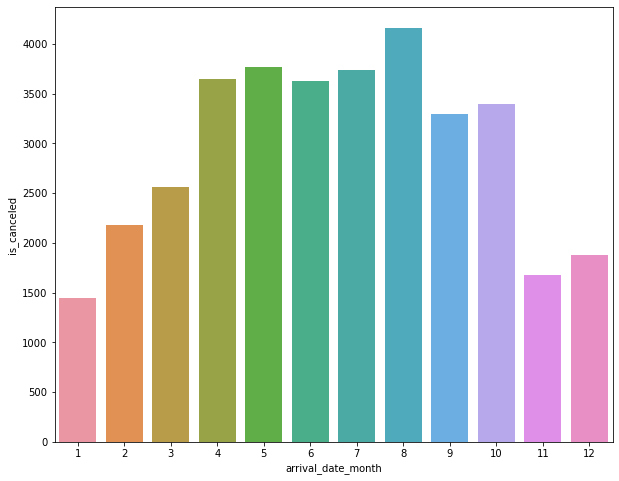

In [135]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.barplot(x=df_train[df_train['is_canceled']==1].groupby('arrival_date_month')['is_canceled'].count().index,
            y=df_train[df_train['is_canceled']==1].groupby('arrival_date_month')['is_canceled'].count())

Se aprecia una mayor cancelación de las reservas en los meses de verano pero posteriormente viendo la correlación de los meses con la variable dependiente se ve que es muy baja y por tanto descartaremos este atributo de mes.

**Tratamiento de valores nulos**

In [136]:
bookings.isnull().sum()

index                                  0
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent           

In [137]:
df1 = df_train.isna()
df2 = pd.crosstab(df1.company, df1.agent)
print (df2)

agent    False  True 
company              
False      178   5303
True     82267   7764


In [138]:
df_train = df_train.drop(columns=['agent', 'company', 'country'])
df_test = df_test.drop(columns=['agent', 'company', 'country'])

In [139]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [140]:
df_train.shape

(95508, 19)

In [141]:
df_test.shape

(23878, 19)

In [142]:
df_train.head()

,hotel,is_canceled,lead_time,arrival_date_month,meal,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,room_is_changed,total_guests,total_nights
85625,City Hotel,0,16,3,BB,Online TA,0,0,0,1,No Deposit,0,Transient-Party,103.0,0,1,0.0,1.0,1
55256,City Hotel,1,82,8,BB,Online TA,0,0,0,0,No Deposit,0,Transient,150.3,0,2,0.0,3.0,8
7157,Resort Hotel,0,284,7,BB,Online TA,0,0,0,0,No Deposit,0,Transient,169.5,1,1,0.0,2.0,5
23544,Resort Hotel,0,2,4,BB,Direct,0,0,0,0,No Deposit,0,Transient,65.0,0,1,0.0,2.0,1
118714,City Hotel,0,2,8,BB,Groups,0,0,0,0,No Deposit,0,Transient-Party,140.0,0,1,0.0,2.0,1


**Análisis de correlación**

In [143]:
df_train.corr(method='pearson')['is_canceled'].sort_values()

room_is_changed                  -0.248243
total_of_special_requests        -0.234210
required_car_parking_spaces      -0.195772
booking_changes                  -0.145862
is_repeated_guest                -0.085060
previous_bookings_not_canceled   -0.056111
arrival_date_month                0.008151
total_nights                      0.016553
total_guests                      0.044438
adr                               0.045367
days_in_waiting_list              0.054818
previous_cancellations            0.109788
lead_time                         0.294141
is_canceled                       1.000000
Name: is_canceled, dtype: float64

In [144]:
df_train = df_train.drop(columns=['arrival_date_month'])
df_test = df_test.drop(columns=['arrival_date_month'])

In [145]:
df_train = df_train.drop(columns=['is_repeated_guest', 'previous_bookings_not_canceled', 'total_nights', 'total_guests',
                                  'adr','days_in_waiting_list'])
df_test = df_test.drop(columns=['is_repeated_guest', 'previous_bookings_not_canceled', 'total_nights', 'total_guests',
                                  'adr','days_in_waiting_list'])

In [146]:
df_train.shape

(95508, 12)

In [147]:
df_test.shape

(23878, 12)

**Tratamiento de los valores duplicados**

In [148]:
df_train.duplicated(keep=False).sum()

76782

In [149]:
df_test.duplicated(keep=False).sum()

15035

In [150]:
df_train = df_train.drop_duplicates()

In [151]:
df_test = df_test.drop_duplicates()

In [152]:
df_train.shape

(31261, 12)

In [153]:
df_test.shape

(12782, 12)

**Análisis univariante**

In [154]:
labels = df_train['is_canceled'].unique()
sizes = df_train['is_canceled'].value_counts()

<BarContainer object of 2 artists>

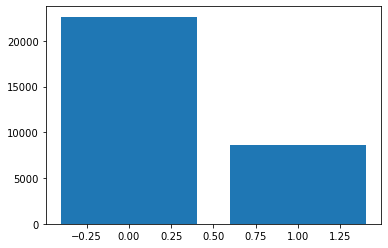

In [155]:
plt.bar(labels, sizes)

In [156]:
labels = df_train['room_is_changed'].unique()
sizes = df_train['room_is_changed'].value_counts()

<BarContainer object of 2 artists>

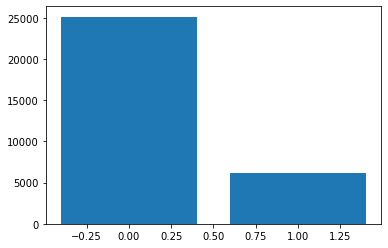

In [157]:
plt.bar(labels, sizes)

In [158]:
labels = df_train['total_of_special_requests'].unique()
sizes = df_train['total_of_special_requests'].value_counts()

<BarContainer object of 6 artists>

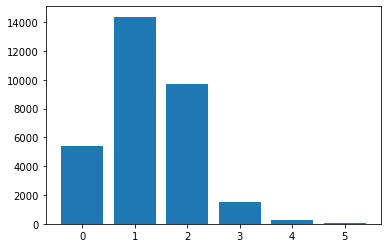

In [159]:
plt.bar(labels, sizes)

In [160]:
labels = df_train['lead_time'].unique()
sizes = df_train['lead_time'].value_counts()

<BarContainer object of 476 artists>

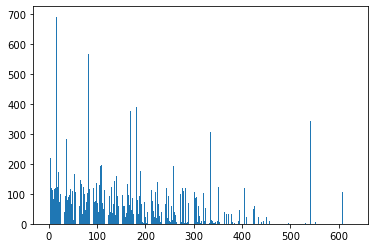

In [161]:
plt.bar(labels, sizes)

**Análisis multivariante**

<AxesSubplot:xlabel='market_segment', ylabel='is_canceled'>

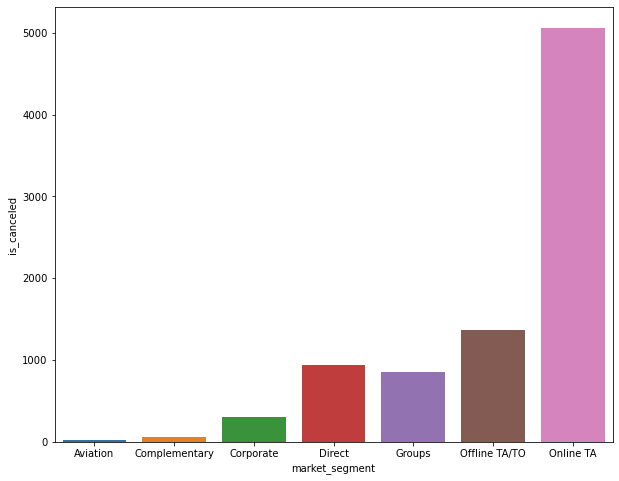

In [162]:
plt.figure(figsize=(10,8))
sns.barplot(x=df_train[df_train['is_canceled']==1].groupby('market_segment')['is_canceled'].count().index,
            y=df_train[df_train['is_canceled']==1].groupby('market_segment')['is_canceled'].count())

<AxesSubplot:xlabel='total_of_special_requests', ylabel='is_canceled'>

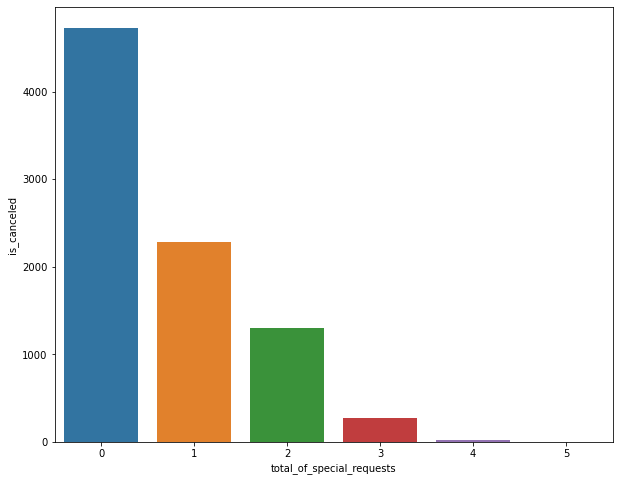

In [163]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.barplot(x=df_train[df_train['is_canceled']==1].groupby('total_of_special_requests')['is_canceled'].count().index,
            y=df_train[df_train['is_canceled']==1].groupby('total_of_special_requests')['is_canceled'].count())

**Minería de datos**

In [164]:
# hotel, meal, market_segment, deposit_type y customer_type,
one_hotHotel = pd.get_dummies(df_train['hotel'])
one_meal = pd.get_dummies(df_train['meal'])
one_market_segment = pd.get_dummies(df_train['market_segment'])
one_deposit_type = pd.get_dummies(df_train['deposit_type'])
one_customer_type = pd.get_dummies(df_train['customer_type'])

dfTrain = df_train.merge(one_hotHotel, left_index=True, right_index=True)
dfTrain = dfTrain.merge(one_meal, left_index=True, right_index=True)
dfTrain = dfTrain.merge(one_market_segment, left_index=True, right_index=True)
dfTrain = dfTrain.merge(one_deposit_type, left_index=True, right_index=True)
dfTrain = dfTrain.merge(one_customer_type, left_index=True, right_index=True)

# hotel, meal, market_segment, deposit_type y customer_type,
one_hotHotel = pd.get_dummies(df_test['hotel'])
one_meal = pd.get_dummies(df_test['meal'])
one_market_segment = pd.get_dummies(df_test['market_segment'])
one_deposit_type = pd.get_dummies(df_test['deposit_type'])
one_customer_type = pd.get_dummies(df_test['customer_type'])

dfTest = df_test.merge(one_hotHotel, left_index=True, right_index=True)
dfTest = dfTest.merge(one_meal, left_index=True, right_index=True)
dfTest = dfTest.merge(one_market_segment, left_index=True, right_index=True)
dfTest = dfTest.merge(one_deposit_type, left_index=True, right_index=True)
dfTest = dfTest.merge(one_customer_type, left_index=True, right_index=True)


In [165]:
dfTrain.shape

(31261, 33)

In [166]:
dfTest.shape

(12782, 33)

In [167]:
dfTrain.corr(method='pearson')['is_canceled'].sort_values()

room_is_changed               -0.225738
required_car_parking_spaces   -0.225426
No Deposit                    -0.222205
booking_changes               -0.106731
total_of_special_requests     -0.104519
Transient-Party               -0.100768
Offline TA/TO                 -0.082666
Direct                        -0.074319
Resort Hotel                  -0.067956
Corporate                     -0.043675
Group                         -0.041107
Contract                      -0.037410
Complementary                 -0.029593
Undefined                     -0.019414
BB                            -0.014612
HB                            -0.005050
Aviation                      -0.000573
FB                             0.003897
Refundable                     0.008782
SC                             0.035501
Groups                         0.038520
City Hotel                     0.067956
previous_cancellations         0.078783
Transient                      0.120757
Online TA                      0.125729


In [168]:
dfTrain = dfTrain.drop(columns=['Offline TA/TO','Direct','Resort Hotel','Corporate','Group','Contract','Complementary',
                                'Undefined','BB','HB','Aviation','FB','Refundable','Groups','SC','City Hotel',
                                'previous_cancellations'])
dfTest = dfTest.drop(columns=['Offline TA/TO','Direct','Resort Hotel','Corporate','Group','Contract','Complementary',
                                'Undefined','BB','HB','Aviation','FB','Refundable','Groups','SC','City Hotel',
                                'previous_cancellations'])

In [169]:
dfTrain.head()

,hotel,is_canceled,lead_time,meal,market_segment,booking_changes,deposit_type,customer_type,required_car_parking_spaces,total_of_special_requests,room_is_changed,Online TA,No Deposit,Non Refund,Transient,Transient-Party
85625,City Hotel,0,16,BB,Online TA,1,No Deposit,Transient-Party,0,1,0.0,1,1,0,0,1
55256,City Hotel,1,82,BB,Online TA,0,No Deposit,Transient,0,2,0.0,1,1,0,1,0
7157,Resort Hotel,0,284,BB,Online TA,0,No Deposit,Transient,1,1,0.0,1,1,0,1,0
23544,Resort Hotel,0,2,BB,Direct,0,No Deposit,Transient,0,1,0.0,0,1,0,1,0
118714,City Hotel,0,2,BB,Groups,0,No Deposit,Transient-Party,0,1,0.0,0,1,0,0,1


Eliminamos las columnas que hemos binarizado

In [170]:
dfTrain = dfTrain.drop(columns=['meal', 'hotel', 'market_segment', 'deposit_type', 'customer_type'])

In [171]:
dfTest = dfTest.drop(columns=['meal', 'hotel', 'market_segment', 'deposit_type', 'customer_type'])

In [172]:
pd.set_option('display.max_columns', None)
dfTrain.head()

,is_canceled,lead_time,booking_changes,required_car_parking_spaces,total_of_special_requests,room_is_changed,Online TA,No Deposit,Non Refund,Transient,Transient-Party
85625,0,16,1,0,1,0.0,1,1,0,0,1
55256,1,82,0,0,2,0.0,1,1,0,1,0
7157,0,284,0,1,1,0.0,1,1,0,1,0
23544,0,2,0,0,1,0.0,0,1,0,1,0
118714,0,2,0,0,1,0.0,0,1,0,0,1


In [173]:
dfTrain.shape

(31261, 11)

In [174]:
dfTest.shape

(12782, 11)

Volvemos a tratar los valores duplicados para los conjuntos que han resultado

In [175]:
dfTrain.duplicated(keep=False).sum()

19611

In [176]:
dfTest.duplicated(keep=False).sum()

6536

In [177]:
dfTrain = dfTrain.drop_duplicates()

In [178]:
dfTest = dfTest.drop_duplicates()

In [179]:
dfTrain.duplicated(keep=False).sum()

0

In [180]:
dfTest.duplicated(keep=False).sum()

0

In [181]:
dfTrain.shape

(18009, 11)

In [182]:
dfTest.shape

(8626, 11)

In [183]:
dfTrain.head()

,is_canceled,lead_time,booking_changes,required_car_parking_spaces,total_of_special_requests,room_is_changed,Online TA,No Deposit,Non Refund,Transient,Transient-Party
85625,0,16,1,0,1,0.0,1,1,0,0,1
55256,1,82,0,0,2,0.0,1,1,0,1,0
7157,0,284,0,1,1,0.0,1,1,0,1,0
23544,0,2,0,0,1,0.0,0,1,0,1,0
118714,0,2,0,0,1,0.0,0,1,0,0,1


In [184]:
dfTrain.corr(method='pearson')['is_canceled'].sort_values()

No Deposit                    -0.253367
required_car_parking_spaces   -0.247795
room_is_changed               -0.214853
total_of_special_requests     -0.110136
Transient-Party               -0.102263
booking_changes               -0.088186
Online TA                      0.066091
Transient                      0.116597
lead_time                      0.132185
Non Refund                     0.260941
is_canceled                    1.000000
Name: is_canceled, dtype: float64

In [185]:
dfTrain['required_car_parking_spaces'].unique()

array([0, 1, 2, 3, 8], dtype=int64)

<AxesSubplot:>

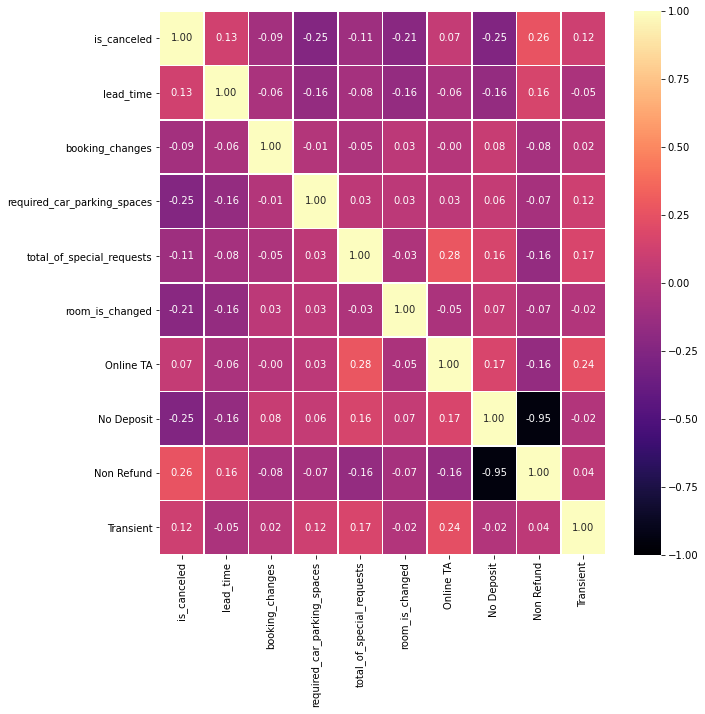

In [186]:
plt.subplots(figsize=(10,10))
sns.heatmap(dfTrain.iloc[:,:10].corr(), vmin=-1, vmax=1, cmap='magma', annot=True, fmt='.2f', linewidth=.5)

**Modelos**

In [187]:
features = ['No Deposit', 'room_is_changed', 'total_of_special_requests', 'required_car_parking_spaces', 
            'booking_changes', 'Transient-Party','Transient', 'Online TA', 'lead_time', 'Non Refund']
x_train = dfTrain[features]
y_train = dfTrain['is_canceled']
x_test = dfTest[features]
y_test = dfTest['is_canceled']

Logistic Regression

In [188]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
logreg = LogisticRegression(solver='liblinear', random_state=0)

In [189]:
logreg.fit(x_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [190]:
y_pred = logreg.predict(x_test)

In [191]:
print('Logistic Regression accuracy score : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Logistic Regression accuracy score : 0.7625


In [192]:
y_pred = logreg.predict(x_test)

acc = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
prec = precision_score(y_test,y_pred)
rec = recall_score(y_test,y_pred)
final_results = pd.DataFrame([['Logistic Regression', acc, f1, prec, rec]],
                     columns =  ['Model','Accuracy Score','F1 score','Precision','Recall'])
final_results

,Model,Accuracy Score,F1 score,Precision,Recall
0,Logistic Regression,0.762462,0.496931,0.661006,0.398112


In [193]:
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared error :", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error :", mae)

r2_value = r2_score(y_test, y_pred)
print("R-Squared Value :", r2_value)

Mean Squared error : 0.2375376767910967
Root Mean Squared Error 0.48737837127953954
Mean absolute error : 0.2375376767910967
R-Squared Value : -0.1428432317344741


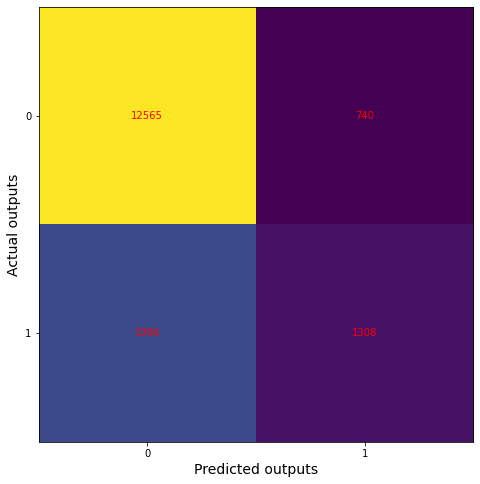

In [194]:
cm = confusion_matrix (y_train, logreg.predict(x_train))

fig, ax = plt.subplots (figsize = (8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize= 14 , color='black')
ax.set_ylabel('Actual outputs', fontsize= 14 , color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
ax.set_ylim(1.5 , -0.5)

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha = 'center' , va = 'center' , color = 'red')

plt.show()

Random Forest

In [195]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0, n_estimators=10)

In [196]:
rfc.fit(x_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=0)

In [197]:
y_pred = rfc.predict(x_test)

In [198]:
training_acc = []
test_acc = []

forest_setting = range(1,100)

for n_estimators in forest_setting:
    RFC = RandomForestClassifier(n_estimators = n_estimators)
    RFC.fit(x_train , y_train.ravel())
    training_acc.append(RFC.score(x_train , y_train))
    test_acc.append(RFC.score(x_test , y_test))

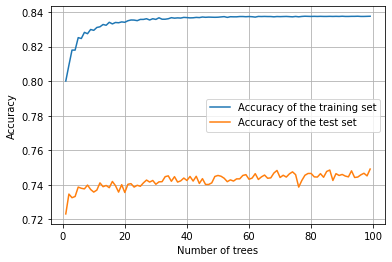

In [199]:
plt.plot(forest_setting , training_acc , label = "Accuracy of the training set")
plt.plot(forest_setting , test_acc , label = "Accuracy of the test set")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.grid(linestyle='-')
plt.legend()

In [200]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.7375


In [201]:
y_pred = rfc.predict(x_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
acc = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
prec = precision_score(y_test,y_pred)
rec = recall_score(y_test,y_pred)
final_results = pd.DataFrame([['Random Forest', acc, f1, prec, rec]],
                     columns =  ['Model','Accuracy Score','F1 score','Precision','Recall'])
final_results

,Model,Accuracy Score,F1 score,Precision,Recall
0,Random Forest,0.737538,0.5441,0.557343,0.531471


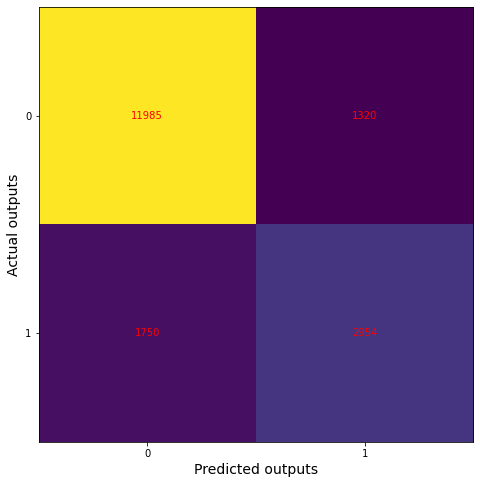

In [202]:
cm = confusion_matrix (y_train, rfc.predict(x_train))

fig, ax = plt.subplots (figsize = (8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize= 14 , color='black')
ax.set_ylabel('Actual outputs', fontsize= 14 , color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
ax.set_ylim(1.5 , -0.5)

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha = 'center' , va = 'center' , color = 'red')

plt.show()

K Neighbors

In [203]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)

In [204]:
neigh.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [205]:
y_pred = neigh.predict(x_test)

In [206]:
training_acc = []
test_acc = []

neighbors_setting = range(1,30)

for n_neighbors in neighbors_setting:
    KNN = KNeighborsClassifier(n_neighbors = n_neighbors)
    KNN.fit(x_train , y_train.ravel())
    training_acc.append(KNN.score(x_train , y_train))
    test_acc.append(KNN.score(x_test , y_test))

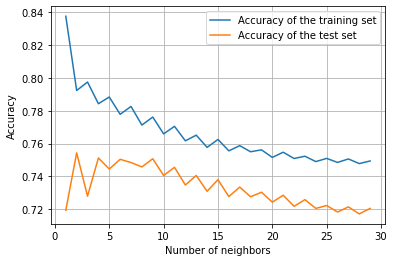

In [207]:
plt.plot(neighbors_setting , training_acc , label = "Accuracy of the training set")
plt.plot(neighbors_setting , test_acc , label = "Accuracy of the test set")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.grid(linestyle='-')
plt.legend()

In [208]:
print('NearestNeighbors accuracy score : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

NearestNeighbors accuracy score : 0.7543


In [209]:
y_pred = neigh.predict(x_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
acc = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
prec = precision_score(y_test,y_pred)
rec = recall_score(y_test,y_pred)
final_results = pd.DataFrame([['Nearest Neighbors', acc, f1, prec, rec]],
                     columns =  ['Model','Accuracy Score','F1 score','Precision','Recall'])
final_results

,Model,Accuracy Score,F1 score,Precision,Recall
0,Nearest Neighbors,0.754347,0.324514,0.855462,0.200236


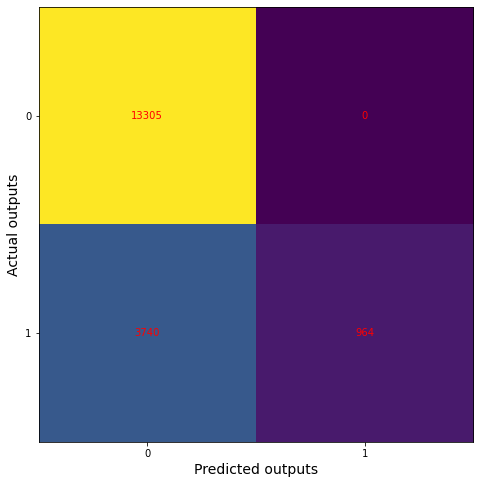

In [210]:
cm = confusion_matrix (y_train, neigh.predict(x_train))

fig, ax = plt.subplots (figsize = (8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize= 14 , color='black')
ax.set_ylabel('Actual outputs', fontsize= 14 , color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
ax.set_ylim(1.5 , -0.5)

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha = 'center' , va = 'center' , color = 'red')

plt.show()

In [211]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
parameters = {"n_neighbors" : range(1,10)}
grid_kn = GridSearchCV(estimator = KNN , param_grid = parameters , scoring = "accuracy" , cv = 5 , verbose = 1 , n_jobs = -1)

grid_kn.fit(x_train , y_train.ravel())
grid_kn.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.7s finished


{'n_neighbors': 8}

Gaussian Nayve Bayes

In [212]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [213]:
gnb.fit(x_train, y_train)

GaussianNB()

In [214]:
y_pred = gnb.predict(x_test)

In [215]:
print('Gaussian Naive Bayes accuracy score : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Gaussian Naive Bayes accuracy score : 0.5908


In [216]:
y_pred = gnb.predict(x_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
acc = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
prec = precision_score(y_test,y_pred)
rec = recall_score(y_test,y_pred)
final_results = pd.DataFrame([['Nearest Neighbors', acc, f1, prec, rec]],
                     columns =  ['Model','Accuracy Score','F1 score','Precision','Recall'])
final_results

,Model,Accuracy Score,F1 score,Precision,Recall
0,Nearest Neighbors,0.590772,0.567296,0.412037,0.910307


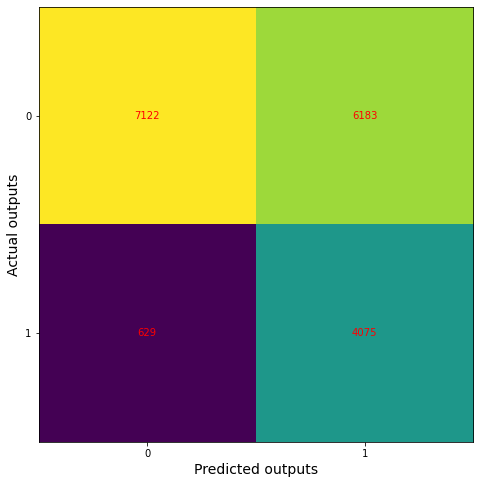

In [217]:
cm = confusion_matrix (y_train, gnb.predict(x_train))

fig, ax = plt.subplots (figsize = (8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize= 14 , color='black')
ax.set_ylabel('Actual outputs', fontsize= 14 , color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
ax.set_ylim(1.5 , -0.5)

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha = 'center' , va = 'center' , color = 'red')

plt.show()